## 2.  Import libraries 

In [1]:
#load the libraries
import pandas as pd # To use the csv data to dataframes
import matplotlib.pyplot as plt # For EDA 
import math # To perform Calculations
import networkx as nx # Node data manipulation
from datetime import timedelta # to convert string data to time data
import datetime as dt #to perform date calcualtions
from sklearn import linear_model # To linear regresion on dataset
import numpy as np # To perform array calculations
%matplotlib inline
import re # To replace strings using regular expressions 
pd.options.mode.chained_assignment = None

## 3. Load the Data
Load all the required datasets

In [2]:
dirty_data = pd.read_csv("inp_data.csv") # Contains data with many errors
node_data = pd.read_csv("inp_other.csv") # Node data for distance calculation
edge_data = pd.read_csv("inp_distance_data.csv") # Distance between nodes, also for distance calculation
branch_data = pd.read_csv("inp_loc.csv") # Geo-locations of the centre of the branches
missing_data = pd.read_csv("inp_missing_information.csv") # Contains a dataset with missing values
outlier_data = pd.read_csv("inp_outlier.csv") # Contains a dataset with values that dont belong
#Let us start by fixing the missing data
missing_data.head(5)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDY02910,19-01-2018,08:30:25,Breakfast,TP,"[('Cereal', 7), ('Pancake', 2)]",195.50,-37.808636,144.960040,0,8.815,11.854358
1,ORDI04912,19-02-2018,09:31:16,Breakfast,NS,"[('Pancake', 1), ('Eggs', 1), ('Cereal', 10)]",256.25,-37.807841,144.945693,0,8.957,14.121648
2,ORDX05190,27-07-2018,14:45:38,Lunch,BK,"[('Chicken', 6), ('Fries', 10), ('Salad', 9), ...",978.80,-37.801293,144.962974,0,8.048,13.637323
3,ORDB04740,19-03-2018,10:32:06,Breakfast,TP,"[('Cereal', 4), ('Pancake', 3), ('Eggs', 7)]",310.75,-37.815218,144.951900,0,8.882,11.472780
4,ORDK01838,03-07-2018,14:05:04,Lunch,BK,"[('Fries', 10), ('Steak', 5), ('Salad', 9)]",499.80,-37.815634,144.966452,0,7.534,13.340968


In [3]:
missing_data.count()

order_id                   500
date                       500
time                       500
order_type                 500
branch_code                400
order_items                500
order_price                500
customer_lat               500
customer_lon               500
customerHasloyalty?        500
distance_to_customer_KM    450
delivery_fee               450
dtype: int64

## Missing data
We shall first impute the missing data and use that data to train our linear model to estimate the delivery fee for the other datasets. There are in total 12 columns in the dataframe and data is missing for three columns as we can see from the above cell. Branch_code, distance_to_customer_KM and delivery_fee have lesser records as compared to other columns. 
The following methodology is followed to impute missing values into each of the columns.

### Imputing missing values for the column: branch_code

Let us impute the missing Branch code data. We do that by noticing that the letters of the order ID are unique to each branch. Using this as reference, we can impute the missing values
After careful observatio, we find that the 4rth letter of the records in the order_id column are helpful in identifying the correspoinding branch code of the order id. There are 3 branches and the following scenarios exist:
1. If the 4rth letter of order_id column record is either 'C'/'I'/'Z', then the branch code has to be 'NS'
2. If the 4rth letter of order_id column record is either 'B'/'J'/'Y', then the branch code has to be 'TP'
3. If the 4rth letter of order_id column record is either 'A'/'K'/'X', then the branch code has to be 'BK'

Hence missing values are imputed by checking the order_id records and inserting the branch code using the above findings.

In [4]:
# Below is the code to fix branch code syntactically and semantically. A for loop is used to run over all the rows and if-else
# condition is used within the loop to check each record and decide which branch it belongs to. A count variable is used to
# check the number of records that were missing and are imputed.
count = 0
for i in range(len(missing_data)):
    if missing_data['order_id'][i][3] in ['C','I','Z'] and missing_data['branch_code'][i] != 'NS':
        missing_data['branch_code'][i] = 'NS'
        count += 1
    elif missing_data['order_id'][i][3] in ['B','J','Y'] and missing_data['branch_code'][i] != 'TP':
        missing_data['branch_code'][i] = 'TP'
        count += 1
    elif missing_data['order_id'][i][3] in ['A','K','X'] and missing_data['branch_code'][i] != 'BK':
        missing_data['branch_code'][i] = 'BK'
        count += 1
count # count of missing data

100

### Imputing missing values for the column: distance_to_customer_KM
We can impute the missing distance values by using the nodes and branches data. The following steps are used to find the missing values in the distance column.
1. Loading the node data into a network dataframe
2. Get the 'from' and 'to' node
3. Use Dijkstra algorithm to find the minimum distance between 'from' and 'to'

We can validate this method by checking the known values

In [5]:
#fix the distances
# From the data stored in the branch_data dataframe(obtained from the branches file), the coordinates of the each branch are 
# stored in a variable corresponding to each branch
ns_coor = (branch_data['branch_lat'][0], branch_data['branch_lon'][0])
tp_coor = (branch_data['branch_lat'][1], branch_data['branch_lon'][1])
bk_coor = (branch_data['branch_lat'][2], branch_data['branch_lon'][2])
#origin coordinates list
origin_list = []
#destination coordinates list
destination_list = []
# A for loop is used to run over all the rows in the missing_data dataframe. The if-else condition is used to check the
# branch_code and hence append the corresponding coordinates of the branch. A destination list is used to obtain the 
# coordinates that are recorded in the missing_data dataframe for all the records.
for i in range(len(missing_data)):
    if missing_data['branch_code'][i] == 'NS':
        origin_list.append(ns_coor)
    elif missing_data['branch_code'][i] == 'TP':
        origin_list.append(tp_coor)
    elif missing_data['branch_code'][i] == 'BK':
        origin_list.append(bk_coor)
    destination_list.append(tuple(list([missing_data['customer_lat'][i],missing_data['customer_lon'][i]])))
# Getting the starting node and final node in order to calculate distance.
# For loops are used to run over the origin_list data and node_data data so as to compare using if-else condition
# the records and find the node id value for starting and ending points and store the starting and ending points in a list
# from_to_node list
from_to_node = []
for i in range(len(origin_list)):
    for j in range(len(node_data)):
        if origin_list[i] == tuple(list([node_data['lat'][j],node_data['lon'][j]])):
            start = node_data['node'][j]
        if destination_list[i] == tuple(list([node_data['lat'][j],node_data['lon'][j]])):
            end = node_data['node'][j]
    from_to_node.append(tuple(list([start,end])))
# loading the node data to the network with distance as weights
D = nx.from_pandas_edgelist(edge_data, 'u', 'v', ['distance(m)'])
# calculating the distance by adding the weights between the nodes iteratively
dist_list = []
for i in range(len(from_to_node)):
    src = from_to_node[i][0]
    des = from_to_node[i][1]
    # Applying Djikstra algorithm to get the minimum distance
    d, p = nx.single_source_dijkstra(D,source=src, target=des,  weight='distance(m)') 
    dist_list.append(d/1000) # distance is stored in a list

Once the distance is calculated we simply impute the missing data

In [6]:
# For loop is used to run over all teh rows in the missing_data dataframe to find the missing values in the 
# 'distance_to_customer_KM' column and replace the blanks with the value from the dist_list list created using the dijkstra
# algorithm. A count variable is used to check the number of values that were missing and then replaced.
count = 0
for i in range(len(missing_data)):
    if pd.isna(missing_data['distance_to_customer_KM'][i]): # check for nulls
        missing_data['distance_to_customer_KM'][i] = dist_list[i] # replce nulls
        count += 1
count

50

### Imputing missing values for the column: delivery_fee

    1. weekday or weekend (values can be 0 or 1)
    2. time of the day (values are morning: 0, afternoon: 1 & evening: 2) 
    3. distance between branch and customer 

Hence, we have to get the day of the week and time of day using the datetime library.

For this we follow the following methodology:
    1. Convert the date column in the missing_data dataframe into date format 
    2. Store the day of the week (using the date column and the datetime library) in a new column
    3. Calculate the time of the day using the order_type column of the missing_data dataframe and the condition mentioned above and store it in a new column 
After this we use linear regression to estimate the delivery fee.

In [7]:
#fix the delivery fee
# the date column of missing_data is converted into date format and then a new column is created to get the day of the week
missing_data['date'] = pd.to_datetime(missing_data['date']) # convert to date
missing_data['Day'] = missing_data['date'].dt.dayofweek #Get day of week
# for loop is used to run over all the rows of the missing_data dataframe and if-else condition is used to find if its a 
# week day or a weekend. For saturday and sunday, the 'day' column value would be 6 and 7 resectively. So the if-else 
# condition checks if the 'day' value is less than 5 and assigns it a 0 value or else assigns it a value of 1.
for i in range(len(missing_data)):
    if missing_data['Day'][i] < 5:
        missing_data['Day'][i] = 0
    else:
        missing_data['Day'][i] = 1
# A new column is created in the missing_data dataframe and initialized to 0.
# for loop is run over all the rows of the missing_data dataframe and if-else condition is used to check each record in 
# order_type column and decide upon the value of the 'time of the day'
missing_data['TOD'] = 0 # Initailize time of day
for i in range(len(missing_data)):
    if missing_data['order_type'][i] == 'Breakfast':
        missing_data['TOD'][i] = 0
    elif missing_data['order_type'][i] == 'Lunch':
        missing_data['TOD'][i] = 1
    elif missing_data['order_type'][i] == 'Dinner':
        missing_data['TOD'][i] = 2
missing_data # to check 

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,Day,TOD
0,ORDY02910,2018-01-19,08:30:25,Breakfast,TP,"[('Cereal', 7), ('Pancake', 2)]",195.50,-37.808636,144.960040,0,8.815,11.854358,0,0
1,ORDI04912,2018-02-19,09:31:16,Breakfast,NS,"[('Pancake', 1), ('Eggs', 1), ('Cereal', 10)]",256.25,-37.807841,144.945693,0,8.957,14.121648,0,0
2,ORDX05190,2018-07-27,14:45:38,Lunch,BK,"[('Chicken', 6), ('Fries', 10), ('Salad', 9), ...",978.80,-37.801293,144.962974,0,8.048,13.637323,0,1
3,ORDB04740,2018-03-19,10:32:06,Breakfast,TP,"[('Cereal', 4), ('Pancake', 3), ('Eggs', 7)]",310.75,-37.815218,144.951900,0,8.882,11.472780,0,0
4,ORDK01838,2018-03-07,14:05:04,Lunch,BK,"[('Fries', 10), ('Steak', 5), ('Salad', 9)]",499.80,-37.815634,144.966452,0,7.534,13.340968,0,1
5,ORDZ02091,2018-07-26,14:45:38,Lunch,NS,"[('Fries', 8), ('Chicken', 5), ('Steak', 2)]",346.00,-37.800662,144.982345,0,7.302,NaN,0,1
6,ORDI08409,2018-02-04,11:02:32,Breakfast,NS,"[('Pancake', 4), ('Cereal', 5)]",202.00,-37.813805,144.957465,0,8.295,13.379527,1,0
7,ORDK07896,2018-02-14,09:21:07,Breakfast,BK,"[('Cereal', 2), ('Eggs', 2), ('Coffee', 9), ('...",299.00,-37.811330,144.962995,0,7.608,12.373437,0,0
8,ORDY04164,2018-12-13,19:29:34,Dinner,TP,"[('Shrimp', 6), ('Pasta', 2), ('Salmon', 5)]",584.00,-37.823761,144.956213,0,7.971,12.217358,0,2
9,ORDK00536,2018-07-28,14:55:46,Lunch,BK,"[('Salad', 3), ('Chicken', 1)]",83.60,-37.804734,144.988256,0,5.824,14.087313,1,1


Now we have all the required data and hence we train our dataset with the non missing values to estimate the missing values.

In [8]:
# Here, we identify the records from each branch using the values in branch_code column and store the records for that
# branch in a new dataframe correspondingly.
ns = missing_data[missing_data['branch_code'] == 'NS']
tp = missing_data[missing_data['branch_code'] == 'TP']
bk = missing_data[missing_data['branch_code'] == 'BK']
# We are dividing the data as data with null values and data without null values. Linear regression can be applied to train 
# the model using the data without null values and then use the model to predict the missing values.
#Hence, three new dataframes are created to store the records with null values in the 'day', 'tod' and 
# 'distance_to_customer_KM' columns for each of the branches.
ns_test = ns[ns.isnull().any(axis=1)][['Day', 'TOD', 'distance_to_customer_KM']]
tp_test = tp[tp.isnull().any(axis=1)][['Day', 'TOD', 'distance_to_customer_KM']]
bk_test = bk[bk.isnull().any(axis=1)][['Day', 'TOD', 'distance_to_customer_KM']]
# The data without any null values is stored in new dataframes for each of the branches. 
ns_train = ns.dropna()[['Day', 'TOD', 'distance_to_customer_KM']]
ns_traget = ns.dropna()['delivery_fee']
tp_train = tp.dropna()[['Day', 'TOD', 'distance_to_customer_KM']]
tp_traget = tp.dropna()['delivery_fee'] 
bk_train = bk.dropna()[['Day', 'TOD', 'distance_to_customer_KM']]
bk_traget = bk.dropna()['delivery_fee']
# Linear regression is applied to train the model and hence predict the missing values in each of the branches 
lm_ns = linear_model.LinearRegression()
model_ns = lm_ns.fit(ns_train, ns_traget) #model fitting
predictions_ns = lm_ns.predict(ns_test) #prediction


In [9]:
lm_tp = linear_model.LinearRegression()
model_tp = lm_tp.fit(tp_train, tp_traget) #model fitting
predictions_tp = lm_tp.predict(tp_test) #prediction

In [10]:
lm_bk = linear_model.LinearRegression()
model_bk = lm_bk.fit(bk_train, bk_traget) #model fitting
predictions_bk = lm_bk.predict(bk_test) #prediction

In [11]:
# for loop is used to run over all the records in the missing_data dataframe and nested if-else condition is used to check 
# for the rows that have data missing for delivery_fee for each branch. the next if-else checks whether the customer has 
# loyalty. As per the question, if the customer has loyalty, he gets a 50% discount 
count_ns = 0
count_tp = 0
count_bk = 0
for i in range(len(missing_data)):
    if pd.isna(missing_data['delivery_fee'][i]):
        if missing_data['branch_code'][i] == 'NS':
            if missing_data['customerHasloyalty?'][i] == 1:
                missing_data['delivery_fee'][i] = predictions_ns[count_ns]/2
                count_ns += 1
            else:
                missing_data['delivery_fee'][i] = predictions_ns[count_ns]
                count_ns += 1
        elif missing_data['branch_code'][i] == 'TP':
            if missing_data['customerHasloyalty?'][i] == 1:
                missing_data['delivery_fee'][i] = predictions_tp[count_tp]/2
                count_tp += 1
            else:
                missing_data['delivery_fee'][i] = predictions_tp[count_tp]
                count_tp += 1
        elif missing_data['branch_code'][i] == 'BK':
            if missing_data['customerHasloyalty?'][i] == 1:
                missing_data['delivery_fee'][i] = predictions_bk[count_bk]/2
                count_bk += 1
            else:
                missing_data['delivery_fee'][i] = predictions_bk[count_bk]
                count_bk += 1
print(count_ns, count_tp, count_bk) # print the number of missing values for each

16 21 13


## Dirty Data

We are now done with the missing dataset, but we will use it once more before we move on. We will use it to calculate the price for each dish by solving linear equations. Using these values we will fix the dirty dataset.

In [12]:
# The 'order_items' column in missing_data dataframe consists of a string which has list the dishes that were ordered 
# The dishes can be divided into breakfast, lunch or dinner dishes depending on the value in 'order_type' column.
# Since, the list is in the format of a (dish, quantity) and we would like to store only the dish name and not the quantity.
# we use another for loop over the list and then apply if-else condition to get the dishes names
break_list = []
lunch_list = []
dinner_list = []
for i in range(len(missing_data)):
    # Break down the string to a list
    order = missing_data['order_items'][i].strip('[]').replace("'","").replace("(","").replace(")",'').replace(" ","").split(",")
    if missing_data['order_type'][i] == 'Breakfast':
        for j in range(len(order)):
            if j % 2 == 0:
                break_list.append(order[j])
            else:
                continue
    elif missing_data['order_type'][i] == 'Lunch':
        for j in range(len(order)):
            if j % 2 == 0:
                lunch_list.append(order[j])
            else:
                continue
    elif missing_data['order_type'][i] == 'Dinner':
        for j in range(len(order)):
            if j % 2 == 0:
                dinner_list.append(order[j])
            else:
                continue
                
# we take only the unique dishes and sort them for breakfast, lunch and dinner               
break_menu = list(set(break_list)) #To get the unique values
break_menu.sort() # Sort the values
lunch_menu = list(set(lunch_list))
lunch_menu.sort()
dinner_menu = list(set(dinner_list))
dinner_menu.sort()
print(break_menu)
print(lunch_menu)
print(dinner_menu)

['Cereal', 'Coffee', 'Eggs', 'Pancake']
['Burger', 'Chicken', 'Fries', 'Salad', 'Steak']
['Fish&Chips', 'Pasta', 'Salmon', 'Shrimp']


In [13]:
# All the records with breakfast orders are extracted
breakfast = missing_data[missing_data['order_type'] == 'Breakfast'] # Get all the breakfast orders
breakfast = breakfast.reset_index(drop=True) # reset index
break_eqs = [] #To store the coefficients
break_sol = [] #To store the solutions
# A for loop is used to initialize the coefficients of breakfast items which are Cereal, Coffee, Eggs & Pancake
for i in range(len(breakfast)):
    coef = [0, 0, 0, 0] #Initialize the coefficients of ['Cereal', 'Coffee', 'Eggs', 'Pancake']
    # Break down the string to a list
    order = breakfast['order_items'][i].strip('[]').replace("'","").replace("(","").replace(")",'').replace(" ","").split(",")
    # The for loop is used to get the quantity for each item in each order and the quantities are stored as coefficients(LHS)
    # for the equation.
    for j in range(0,len(order),2):
        if order[j] == 'Cereal':
            coef[0] = order[j+1]
        elif order[j] == 'Coffee':
            coef[1] = order[j+1]
        elif order[j] == 'Eggs':
            coef[2] = order[j+1]
        elif order[j] == 'Pancake':
            coef[3] = order[j+1]
    break_eqs.append(coef)
    # The order_price is stored as the solution(RHS) of the equation
    break_sol.append(breakfast['order_price'][i])
#print(break_eqs)
#print(break_sol)
# The relevant equations are considered as the coefficients for the other equations were mostly zeroes and solution could 
# not be calculated
a = np.array(break_eqs[5:9], dtype=float) #Get suitable coefficients
b = np.array(break_sol[5:9], dtype=float)
break_prices = np.linalg.solve(a, b) #Solve equations
break_prices = np.round(break_prices,2) #Round results
break_dict = {} #Store results in a dictionary for later use
#A dictionary with the breafast items as keys and prices as values is created
for i in range(len(break_menu)):
    break_dict[break_menu[i]] = break_prices[i]
break_dict

{'Cereal': 21.0, 'Coffee': 7.5, 'Eggs': 22.0, 'Pancake': 24.25}

In [14]:
# All the records with lunch orders are extracted
lunch = missing_data[missing_data['order_type'] == 'Lunch'] # Get all the lunch orders
lunch = lunch.reset_index(drop=True) # reset index
lunch_eqs = [] #To store the coefficients
lunch_sol = [] #To store the solutions
# A for loop is used to initialize the coefficients of lunch items which are ['Burger', 'Chicken', 'Fries', 'Salad', 'Steak']
for i in range(len(lunch)):
    coef = [0, 0, 0, 0, 0]
     # Break down the string to a list
    order = lunch['order_items'][i].strip('[]').replace("'","").replace("(","").replace(")",'').replace(" ","").split(",")
    # The for loop is used to get the quantity for each item in each order and the quantities are stored as coefficients(LHS)
    # for the equation.
    for j in range(0,len(order),2):
        if order[j] == 'Burger':
            coef[0] = order[j+1]
        elif order[j] == 'Chicken':
            coef[1] = order[j+1]
        elif order[j] == 'Fries':
            coef[2] = order[j+1]
        elif order[j] == 'Salad':
            coef[3] = order[j+1]
        elif order[j] == 'Steak':
            coef[4] = order[j+1]
    lunch_eqs.append(coef)
    # The order_price is stored as the solution(RHS) of the equation
    lunch_sol.append(lunch['order_price'][i])
# print(lunch_eqs)
# print(lunch_sol)
a = np.array(lunch_eqs[0:5], dtype=float) 
b = np.array(lunch_sol[0:5], dtype=float)
lunch_prices = np.linalg.solve(a, b) #Solve equations
lunch_prices = np.round(lunch_prices,2) #Rounding the results
lunch_dict = {} #Store results in a dictionary for later use
#A dictionary with the lunch items as keys and prices as values is created
for i in range(len(lunch_menu)):
    lunch_dict[lunch_menu[i]] = lunch_prices[i]
lunch_dict

{'Burger': 31.0, 'Chicken': 32.0, 'Fries': 12.0, 'Salad': 17.2, 'Steak': 45.0}

In [15]:
# All the records with dinner orders are extracted
dinner = missing_data[missing_data['order_type'] == 'Dinner'] # Get all the dinner orders
dinner = dinner.reset_index(drop=True) # reset index
dinner_eqs = [] #To store the coefficients
dinner_sol = [] #To store the solutions
# A for loop is used to initialize the coefficients of dinner items which are ['Fish&Chips', 'Pasta', 'Salmon', 'Shrimp']
for i in range(len(dinner)):
    coef = [0, 0, 0, 0]
    # Break down the string to a list
    order = dinner['order_items'][i].strip('[]').replace("'","").replace("(","").replace(")",'').replace(" ","").split(",")
    # The for loop is used to get the quantity for each item in each order and the quantities are stored as coefficients(LHS)
    # for the equation.
    for j in range(0,len(order),2):
        if order[j] == 'Fish&Chips':
            coef[0] = order[j+1]
        elif order[j] == 'Pasta':
            coef[1] = order[j+1]
        elif order[j] == 'Salmon':
            coef[2] = order[j+1]
        elif order[j] == 'Shrimp':
            coef[3] = order[j+1]
    dinner_eqs.append(coef)
    # The order_price is stored as the solution(RHS) of the equation
    dinner_sol.append(dinner['order_price'][i])
# print(dinner_eqs)
# print(dinner_sol)
# The relevant equations are considered as the coefficients for the other equations were mostly zeroes and solution could 
# not be calculated
a = np.array(dinner_eqs[5:9], dtype=float)
b = np.array(dinner_sol[5:9], dtype=float)
dinner_prices = np.linalg.solve(a, b)  #Solve equations
dinner_prices = np.round(dinner_prices,2) #Rounding the results
dinner_dict = {} #Store results in a dictionary for later use
#A dictionary with the dinner items as keys and prices as values is created
for i in range(len(dinner_menu)):
    dinner_dict[dinner_menu[i]] = dinner_prices[i]
dinner_dict

{'Fish&Chips': 35.0, 'Pasta': 27.5, 'Salmon': 41.0, 'Shrimp': 54.0}

### Checking for Errors in the column: order_id

In [16]:
# Below is the code to check if order ID is unique for each record. A new column is created to store the order_id if it is
# duplicated
dirty_data['Duplicate'] = dirty_data.duplicated(['order_id'])
dirty_data[dirty_data['Duplicate'] == True]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,Duplicate


### Checking & Fixing Errors in the column: branch_code
We check the distribution of the branches by plotting a bar graph to see if there are any errors

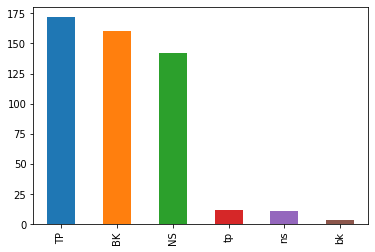

In [17]:
# Plotting the distribution of branch_code column
dirty_data['branch_code'].value_counts().plot('bar')

We can see that there are syntactic errors in the branch code. We shall fix that and any symantic errors using the same method we used for the missing data.
After careful observatio, we find that the 4rth letter of the records in the order_id column are helpful in identifying the correspoinding branch code of the order id. There are 3 branches and the following scenarios exist:
    1. If the 4rth letter of order_id column record is either 'C'/'I'/'Z', then the branch code has to be 'NS'
    2. If the 4rth letter of order_id column record is either 'B'/'J'/'Y', then the branch code has to be 'TP'
    3. If the 4rth letter of order_id column record is either 'A'/'K'/'X', then the branch code has to be 'BK'

In [18]:
# Below is the code to fix branch_code syntactically and semantically. A for loop is used to run over all the rows and if-else
# condition is used within the loop to check each record and decide which branch it belongs to. A count variable is used to
# check how many errors were there in the data
count = 0
for i in range(len(dirty_data)):
    if dirty_data['order_id'][i][3] in ['C','I','Z'] and dirty_data['branch_code'][i] != 'NS':
        dirty_data['branch_code'][i] = 'NS'
        count += 1
    elif dirty_data['order_id'][i][3] in ['B','J','Y'] and dirty_data['branch_code'][i] != 'TP':
        dirty_data['branch_code'][i] = 'TP'
        count += 1
    elif dirty_data['order_id'][i][3] in ['A','K','X'] and dirty_data['branch_code'][i] != 'BK':
        dirty_data['branch_code'][i] = 'BK'
        count += 1
count

37

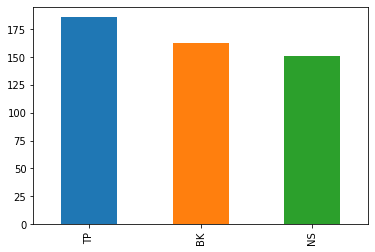

In [19]:
# Plotting the graph to recheck the distribution
dirty_data['branch_code'].value_counts().plot('bar')

### Fixing Errors in the column: date
Let us move on to the date formats. When we run the two code blocks below, we get errors. This indicates that not all the dates are the same formats. The code has been commented.

In [20]:
# #check date formats
# pd.to_datetime(dirty_data['date'], format='%Y-%m-%d', errors='raise')

In [21]:
# #convert the date formats to a single format
# dirty_data['clean_date'] = dirty_data.date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d')[0])

In [22]:
# The date should be in the YYYY-MM-DD format as per the specifications given in the assignment. Hence, for loop is used to 
# loop over all the values in the date column in dirty_data dataframe
for i in range(len(dirty_data)):
    for form in ['%d-%m-%Y','%Y-%d-%m']:
        try:
            dirty_data['date'][i] = dt.datetime.strptime(str(dirty_data['date'][i]),form).date()
        except ValueError:
            continue
#Convert to datetime
dirty_data['date'] = pd.to_datetime(dirty_data.date)
#Convert to correct format
dirty_data['date'] = dirty_data['date'].dt.strftime('%Y-%m-%d')

### Fixing Errors in the column: time

In [23]:
#Convert time to correct format(hh:mm:ss format) as gievn in the specifications of the assignment
dirty_data['time'] = pd.to_timedelta(dirty_data['time'].str.strip())

### Checking & Fixing Errors in the column: order_type
We check the order type by cross referencing it with the time of the order. 

    1. Breakfast - served during morning (8am - 12pm)
    2. Lunch - served during afternoon (12:00:01pm - 4pm) 
    3. Dinner - served during evening (4:00:01pm - 8pm) 
    
  Hence, by checking the time of the order, we can verify if the order_type is correct 

In [24]:
# for loop is used to loop over all the rows in the dirty_data dataframe and an if-else condition is used to verify the 
# order_type against the time as per the conditions mentioned in the previous cell. If the order_type value is not matching 
# with the time, it is replaced with the correct order_type.
count = 0
for i in range(len(dirty_data)):
    if dirty_data['time'][i] >= timedelta(hours=8)\
    and dirty_data['time'][i] <= timedelta(hours=12)\
    and dirty_data['order_type'][i] != 'Breakfast':
        dirty_data['order_type'][i] = 'Breakfast'
        count += 1
    elif dirty_data['time'][i] > timedelta(hours=12)\
    and dirty_data['time'][i] <= timedelta(hours=16)\
    and dirty_data['order_type'][i] != 'Lunch':
        dirty_data['order_type'][i] = 'Lunch'
        count += 1
    elif dirty_data['time'][i] > timedelta(hours=16)\
    and dirty_data['time'][i] <= timedelta(hours=20)\
    and dirty_data['order_type'][i] != 'Dinner':
        dirty_data['order_type'][i] = 'Dinner'
        count += 1
count

37

### Fixing Errors in the column: order_items
We use the same technique as above to break down the order then we find the dish out of place, and use the price to get the actual dish using the dictionary we made earlier.

Methodology:
1. Get the order items
2. Check whether order items are from the breakfast menu which we got from the missing data
3. Once we find the error, we deduct the price of the items which are correct from the total order price so that only the price of the error item remains
4. We get the unit term of the error item by dividing the remaining price by order quantity of teh error item
5. Now, we cross reference that unit price with the prce given in the menu dictionary to get the correct item name
6. Replace the error item with the correct item using regex

In [25]:
# A for loop is used to loop over all the rows in the dirty_data dataframe
count = 0
for i in range(len(dirty_data)):
    order = dirty_data['order_items'][i].strip('[]').replace("'","").replace("(","").replace(")",'').replace(" ","").split(",")
    if dirty_data['order_type'][i] == 'Breakfast':
        price = dirty_data['order_price'][i]
        mult = 0
        for j in range(0,len(order),2): # iterate through the order items
            if order[j] not in break_menu:
                count += 1
                outter = order[j] # Save the error item
                mult = int(order[j+1]) # Save the quantity of the error item
            else:
                # otherwise deduct the price of the correct items from the order price
                price -= int(order[j+1]) * break_dict[order[j]] 
        if mult != 0:
            price = round(price/mult, 2) # To get the unit price of the error item
            #Cross reference the error item unit price with the menu price & get the index
            index = np.where(break_prices == price)[0][0] 
            # Replace the item name using regex
            dirty_data['order_items'][i] = re.sub(outter, break_menu[index], dirty_data['order_items'][i]) 
    elif dirty_data['order_type'][i] == 'Lunch':
        price = dirty_data['order_price'][i]
        mult = 0
        for j in range(0,len(order),2):  # iterate through the order items
            if order[j] not in lunch_menu:
                count += 1
                outter = order[j] # Save the error item
                mult = int(order[j+1]) # Save the quantity of the error item
            else:
                # otherwise deduct the price of the correct items from the order price
                price -= int(order[j+1]) * lunch_dict[order[j]]
        if mult != 0:
            price = round(price/mult, 2) # To get the unit price of the error item
            #Cross reference the error item unit price with the menu price & get the index
            index = np.where(lunch_prices == price)[0][0]
            # Replace the item name using regex
            dirty_data['order_items'][i] = re.sub(outter, lunch_menu[index], dirty_data['order_items'][i])
    elif dirty_data['order_type'][i] == 'Dinner':
        price = dirty_data['order_price'][i]
        mult = 0
        for j in range(0,len(order),2): # iterate through the order items
            if order[j] not in dinner_menu:
                count += 1
                outter = order[j] # Save the error item
                mult = int(order[j+1])  # Save the quantity of the error item
            else:
                # otherwise deduct the price of the correct items from the order price                
                price -= int(order[j+1]) * dinner_dict[order[j]]
        if mult != 0:
            price = round(price/mult, 2) # To get the unit price of the error item
            #Cross reference the error item unit price with the menu price & get the index
            index = np.where(dinner_prices == price)[0][0]
            # Replace the item name using regex
            dirty_data['order_items'][i] = re.sub(outter, dinner_menu[index], dirty_data['order_items'][i])
count # Count of error

37

Now, we check the wheteher all the menu items are unique to the type

In [26]:
#Check whether the meals are unique to the menu
# A for loop is used to loop over the dirty_data dataframe to verify if the items in order are matching with their corresponding
# order_type
break_list = []
lunch_list = []
dinner_list = []
for i in range(len(dirty_data)):
    # Break down the string to a list
    order = dirty_data['order_items'][i].strip('[]').replace("'","").replace("(","").replace(")",'').replace(" ","").split(",")
    if dirty_data['order_type'][i] == 'Breakfast':
        for j in range(len(order)):
            if j % 2 == 0:
                break_list.append(order[j])
            else:
                continue
    elif dirty_data['order_type'][i] == 'Lunch':
        for j in range(len(order)):
            if j % 2 == 0:
                lunch_list.append(order[j])
            else:
                continue
    elif dirty_data['order_type'][i] == 'Dinner':
        for j in range(len(order)):
            if j % 2 == 0:
                dinner_list.append(order[j])
            else:
                continue
break_menu = list(set(break_list))
#break_menu.sort()
lunch_menu = list(set(lunch_list))
#lunch_menu.sort()
dinner_menu = list(set(dinner_list))
#dinner_menu.sort()
#Print the menus
print(break_menu)
print(lunch_menu)
print(dinner_menu)

['Eggs', 'Pancake', 'Cereal', 'Coffee']
['Steak', 'Fries', 'Burger', 'Salad', 'Chicken']
['Pasta', 'Fish&Chips', 'Salmon', 'Shrimp']


### Checking & Fixing errors in the customer_lat and customer_lon
We check the validity of the coordinates by plotting them on a graph.

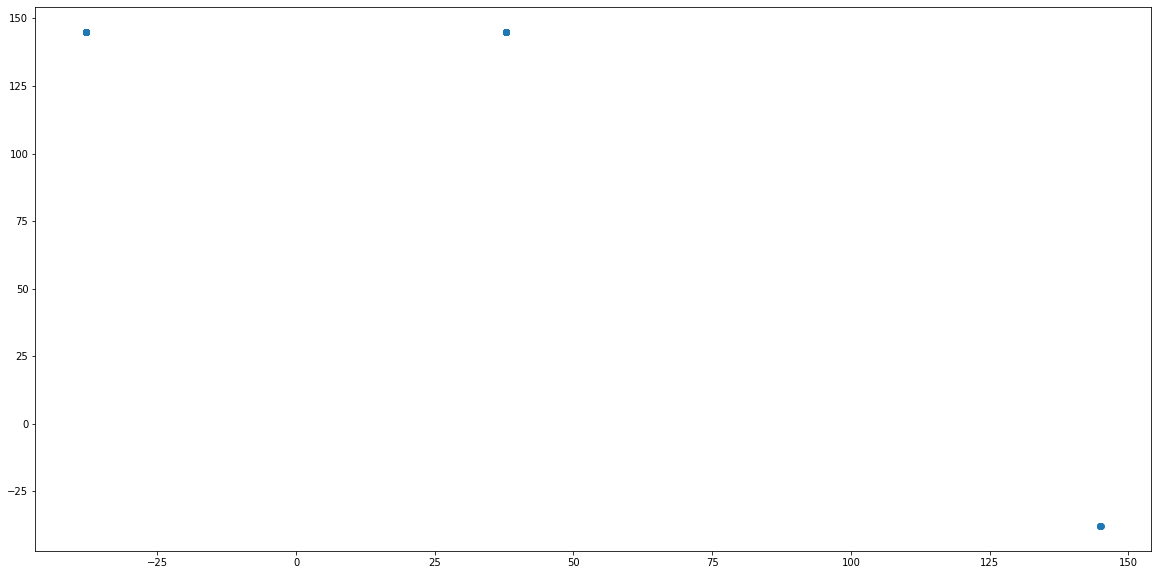

In [27]:
# Plotting the graph with latitude on X-Axis and longitude on Y-Axis
plt.figure(figsize=(20,10))
plt.scatter(x = dirty_data['customer_lat'], y = dirty_data['customer_lon'])
plt.show()

We can see that some of the coordinates have the following errors:
* Interchanged latitudes and longitudes
* Inverse signs

In [28]:
#Check Latitudes
# A for loop is used to loop over all the values of latitudes in the dataframe and using nested if-else, we check
# if they are positive and if it is exceeding 40. If the latitude value is exceeding 40, it means that the latitude & longitude 
# value are interchanged. If it is negative, then multiple with -1 so as to make it a positive value as the latitudes have  
# to be positive

count = 0
for i in range(len(dirty_data)):
    if dirty_data['customer_lat'][i] > 0:
        count += 1
        if dirty_data['customer_lat'][i] > 40:
            temp = dirty_data['customer_lat'][i]
            dirty_data['customer_lat'][i] = dirty_data['customer_lon'][i]
            dirty_data['customer_lon'][i] = temp
        else:
            dirty_data['customer_lat'][i] = dirty_data['customer_lat'][i] * -1
count # Count of error

41

In [29]:
#Check longitudes
# A for loop is used to loop over all the values of longitudes in the dataframe and using if condition, we check if the 
# longitudes are negative, if it is negative it is multiplied with -1 so as to make it positive
count = 0
for i in range(len(dirty_data)):
    if dirty_data['customer_lon'][i] < 0:
        count += 1
        dirty_data['customer_lon'][i] = -1 * dirty_data['customer_lon'][i]
count # Count of error

0

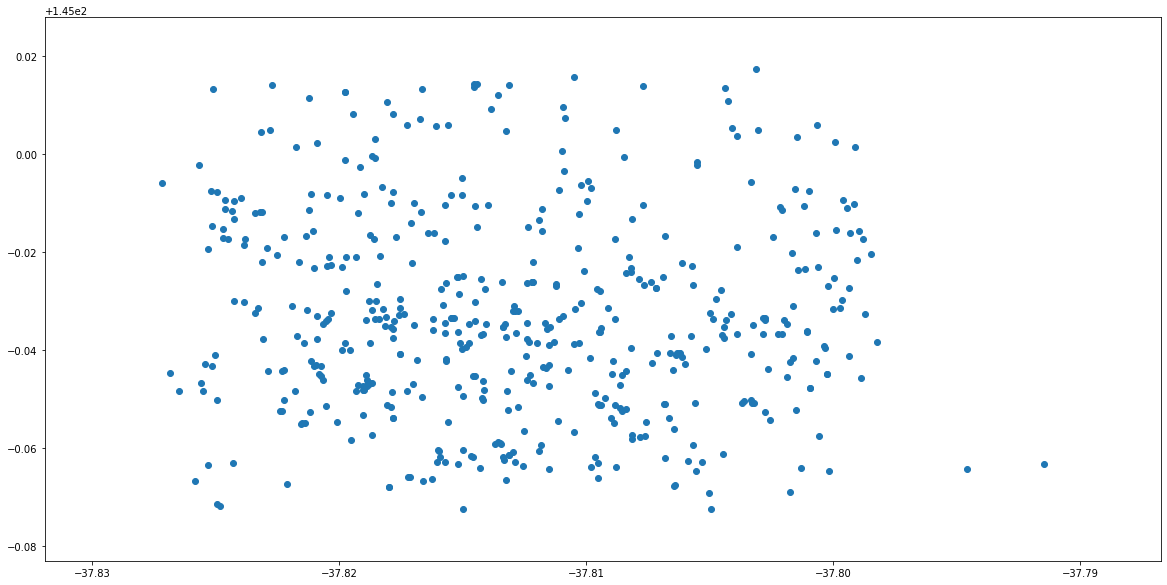

In [30]:
# Plotting the graph with latitude on X-Axis and longitude on Y-Axis
plt.figure(figsize=(20,10))
plt.scatter(x = dirty_data['customer_lat'], y = dirty_data['customer_lon'])
plt.show()

We can see that the coordinates are now proper.

### Checking & Fixing errors in the column: distance_to_customer_KM
Now let us calculate the distance using the same method we used for the missing data.

In [31]:
# origin coordinates list
origin_list = []
#destination coordinates list
destination_list = []
# A for loop is used to run over all the rows in the dataframe. The if-else condition is used to check the
# branch_code and hence append the corresponding coordinates of the branch. A destination list is used to obtain the 
# coordinates that are recorded in the dataframe for all the records.
for i in range(len(dirty_data)):
    if dirty_data['branch_code'][i] == 'NS':
        origin_list.append(ns_coor)
    elif dirty_data['branch_code'][i] == 'TP':
        origin_list.append(tp_coor)
    elif dirty_data['branch_code'][i] == 'BK':
        origin_list.append(bk_coor)
    destination_list.append(tuple(list([dirty_data['customer_lat'][i],dirty_data['customer_lon'][i]])))
# Getting the starting node and final node in order to calculate distance
# For loops are used to run over the origin_list data and node_data data so as to compare using if-else condition
# the records and find the node id value for starting and ending points and store the starting and ending points in a list
# from_to_node list
from_to_node = []
for i in range(len(origin_list)):
    for j in range(len(node_data)):
        if origin_list[i] == tuple(list([node_data['lat'][j],node_data['lon'][j]])):
            start = node_data['node'][j]
        if destination_list[i] == tuple(list([node_data['lat'][j],node_data['lon'][j]])):
            end = node_data['node'][j]
    from_to_node.append(tuple(list([start,end])))
# loading the node data to the network with distance as weights
D = nx.from_pandas_edgelist(edge_data, 'u', 'v', ['distance(m)'])
# calculating the distance by adding the weights between the nodes iteratively
dist_list = []
for i in range(len(from_to_node)):
    src = from_to_node[i][0]
    des = from_to_node[i][1]
    # Applying Djikstra algorithm to get the minimum distance
    d, p = nx.single_source_dijkstra(D,source=src, target=des,  weight='distance(m)')
    dist_list.append(d/1000) # Convert to kilometers
dist_list

[9.84,
 8.147,
 6.552,
 9.559,
 11.621,
 6.704,
 7.333,
 9.781,
 8.531,
 9.025,
 10.859,
 7.208,
 7.456,
 9.653,
 8.973,
 8.227,
 10.202,
 6.945,
 8.445,
 7.412,
 4.119,
 7.508,
 8.706,
 7.215,
 4.369,
 7.638,
 12.196,
 8.879,
 9.657,
 11.898,
 7.947,
 6.78,
 7.656,
 7.397,
 9.651,
 8.497,
 9.162,
 9.028,
 8.992,
 8.186,
 8.95,
 4.107,
 8.716,
 10.067,
 8.238,
 10.699,
 10.614,
 8.417,
 10.151,
 7.952,
 9.472,
 6.942,
 11.033,
 9.051,
 8.826,
 5.607,
 10.569,
 8.43,
 9.488,
 9.826,
 9.256,
 11.796,
 9.43,
 9.201,
 11.081,
 6.753,
 9.552,
 6.985,
 8.111,
 11.463,
 9.168,
 8.274,
 9.699,
 9.467,
 8.303,
 8.871,
 7.102,
 9.083,
 10.095,
 10.287,
 6.695,
 4.993,
 12.131,
 6.982,
 4.882,
 8.945,
 7.081,
 8.334,
 7.677,
 5.082,
 9.684,
 8.869,
 7.949,
 8.944,
 10.742,
 8.851,
 9.997,
 10.337,
 10.414,
 7.87,
 11.924,
 9.245,
 7.757,
 9.527,
 9.51,
 8.295,
 5.319,
 9.22,
 4.457,
 5.939,
 9.939,
 9.005,
 7.409,
 4.615,
 7.464,
 9.973,
 7.601,
 10.446,
 7.269,
 10.218,
 6.545,
 5.524,
 10.561,


Replace the values that don't match.

In [32]:
#Replace the values that dont match in the distance_to_customer_KM with the above calculated values
count = 0
for i in range(len(dirty_data)):
    if round(dirty_data['distance_to_customer_KM'][i],3) != dist_list[i]:
        dirty_data['distance_to_customer_KM'][i] = dist_list[i]
        count += 1
count

37

### Checking & Fixing the errors in loyalty column
Let us check the distribution of the loyalty columns

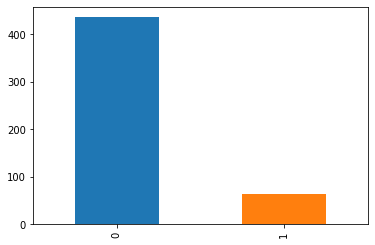

In [33]:
dirty_data['customerHasloyalty?'].value_counts().plot('bar')

The distribution for the loyalty memberbership seems to favor non-loyalty members. This could be an error. Let us verify the loyalty status by comparing the ratio of delivery fee to predicted delivery fee. If the ratio is close to 1:1 and loyalty is 0, the it is correct. If the ratio is 1:2 and loyalty is 1, that is also correct. The other ratios will be considered wrong and the value of loyalty will have to be changed.

First let us prepare the data to use for predicting the data.

Use the same steps to get the required data from the date and use the model from missng data to predict the values.

In [34]:
dirty_data['date'] = pd.to_datetime(dirty_data['date'])  # convert to date
dirty_data['Day'] = dirty_data['date'].dt.dayofweek #Get day of week
# for loop is used to run over all the rows of the dataframe and if-else condition is used to find if its a
# week day or a weekend. For saturday and sunday, the 'day' column value would be 6 and 7 resectively. So the if-else 
# condition checks if the 'day' value is less than 5 and assigns it a 0 value or else assigns it a value of 1.
for i in range(len(dirty_data)):
    if dirty_data['Day'][i] < 5:
        dirty_data['Day'][i] = 0
    else:
        dirty_data['Day'][i] = 1
# A new column is created in the missing_data dataframe and initialized to 0.
# for loop is run over all the rows of the dataframe and if-else condition is used to check each record in
# order_type column and decide upon the value of the 'time of the day'
dirty_data['TOD'] = 0
for i in range(len(dirty_data)):
    if dirty_data['order_type'][i] == 'Breakfast':
        dirty_data['TOD'][i] = 0
    elif dirty_data['order_type'][i] == 'Lunch':
        dirty_data['TOD'][i] = 1
    elif dirty_data['order_type'][i] == 'Dinner':
        dirty_data['TOD'][i] = 2

In [35]:
# Here, we identify the records from each branch using the values in branch_code column and store the records for that
# branch in a new dataframe correspondingly.
ns = dirty_data[dirty_data['branch_code'] == 'NS']
tp = dirty_data[dirty_data['branch_code'] == 'TP']
bk = dirty_data[dirty_data['branch_code'] == 'BK']
# The data without any null values is stored in new dataframes for each of the branches. 
ns_train = ns[['Day', 'TOD', 'distance_to_customer_KM']]
tp_train = tp[['Day', 'TOD', 'distance_to_customer_KM']]
bk_train = bk[['Day', 'TOD', 'distance_to_customer_KM']]
# Linear regression is applied to train the model and hence predict the missing values in each of the branches 
predictions_ns = lm_ns.predict(ns_train) #prediction
predictions_ns #print predictions

array([12.50738553, 15.15465173, 15.24626477, 17.10193189, 12.07746538,
       13.67569263, 13.96447125, 13.18562891, 15.29055108, 15.36150057,
       14.81212143, 17.1060679 , 16.06894104, 15.80110399, 11.32996178,
       14.84844082, 13.63874651, 11.62474004, 13.6038985 , 14.34286855,
       14.43333187, 12.34014744, 15.42493552, 12.27342113, 13.43479677,
       16.34390039, 14.20727428, 16.77213127, 11.15427732, 13.26097595,
       13.55304593, 14.83315017, 14.76772088, 13.67391618, 14.46142279,
       13.02047235, 15.11450142, 12.68813781, 14.06489585, 12.28524604,
       12.82367196, 12.1627737 , 15.5254473 , 12.79625133, 16.06294141,
       15.76900779, 15.47637118, 13.03359428, 15.12210315, 12.53610318,
       11.85194735, 14.22239056, 13.60043277, 15.22644586, 15.59003196,
       16.10010543, 14.89188249, 15.77883835, 13.77865115, 16.29530371,
       14.60003041, 14.73055686, 12.77429077, 13.59452032, 12.03101035,
       14.57975912, 14.64111253, 12.1907339 , 14.73478004, 15.14

In [36]:
predictions_tp = lm_tp.predict(tp_train) #prediction
predictions_tp

array([13.88054798, 14.4219305 , 12.1018253 , 14.11826743, 11.07161591,
       14.37835476, 14.17873101, 10.95493502, 10.80885241, 13.68360038,
       15.5757432 , 12.60758325, 12.79922175, 13.60839093, 11.07408704,
       11.04443348, 10.3805232 , 13.24101626, 12.84728287, 13.37615152,
       11.49644525, 12.6117018 , 12.65177766, 11.09303237, 14.48103259,
       11.26189292, 15.77804312, 12.3308635 , 12.42855224, 13.97712708,
       13.92963783, 11.53070832, 16.42939272, 12.11505147, 12.87693643,
       14.97636824, 13.85962248, 13.36869131, 14.37691238, 13.85200406,
       14.96401259, 10.94311714, 13.42882214, 14.29618879, 13.4277125 ,
       15.59715966, 11.48511834, 13.89504201, 11.98078674, 10.95246389,
       13.06445638, 13.26626534, 14.47444291, 14.09636001, 11.74520567,
       13.75719651, 14.03322027, 12.56500218, 10.2404925 , 15.08584077,
       11.19023015, 11.28277161, 12.98764632, 11.60896077, 11.51889045,
       15.13608708, 11.25118469, 11.09385608, 12.47056146, 10.34

In [37]:
predictions_bk = lm_bk.predict(bk_train) #prediction
predictions_bk

array([10.78406417, 16.94653212, 14.19768829, 16.56455687, 12.9819049 ,
       14.03042134, 12.79608936, 14.24031554, 10.07516724, 14.90438807,
       13.05605007,  8.68223367, 13.02454038, 15.40725029, 13.41324712,
       13.23128285, 11.69725137, 14.69502866, 16.24078692, 11.50783961,
       13.93632851, 14.78718762, 14.38018735,  9.28303176, 17.78926067,
       12.83171361, 12.44343489, 12.92703254, 12.63599838, 16.38450178,
       17.69560409, 13.57789713, 17.29576334, 14.4304186 , 16.620137  ,
       10.40059954, 11.827495  , 12.18636263, 11.66215369, 13.04063676,
       11.36052031, 11.76272295, 12.8201598 , 12.14163678, 11.59957055,
       13.88984999, 16.06292898, 14.60303444, 14.77055644, 18.85167634,
       12.64877829, 13.71199204, 17.51362336, 15.51867383, 12.08579337,
       12.58811256, 18.40256716, 16.15123667, 17.68693051, 16.18398069,
       14.63699633, 16.77680473, 14.48845916, 12.28579611, 14.13948299,
       12.38811805, 13.58271122, 18.97780543, 22.34504957, 12.87

Methodology:
    1. Assume that the delivery fee column is accurate
    2. Group the customers based on their loyalty status (either 0 or 1)
    3. Divide the original delivery fee with the predicted delivery fee
    4. Customers who dont have loyalty will have the division value from the previous step close to 1
    5. Customers who dont have loyalty will have the division value from the previous step close to 0.5
    6. If the division values dont match up, we change customer's loyalty class

In [38]:
# Now let us verify the loyalty column.
# For loop is used to loop over all the rows in the dataframe and nested if-else condition is used to identify the branch 
# using branch code. Then, if the ratio is close to one (range considered is 0.8 to 1.2), then it means the person does not have loyalty as the original delivery fee is 
# similar to the predicted value. If the ratio is close to 0.5 (range considered is 0.3 to 0.7), then it means the person does has loyalty as the original delivery fee is 
# is discounted and hence the value is not similar to the predicted value. This is applied to all 3 branches.
count_ns = 0
count_tp = 0
count_bk = 0
count = 0
for i in range(len(dirty_data)):
    if dirty_data['branch_code'][i] == 'NS':
        if dirty_data['customerHasloyalty?'][i] == 1:
            ratio = dirty_data['delivery_fee'][i]/predictions_ns[count_ns]
            if ratio >= 0.8 and ratio <= 1.2:
                dirty_data['customerHasloyalty?'][i] = 0
                count += 1
            count_ns += 1
        else:
            ratio = dirty_data['delivery_fee'][i]/predictions_ns[count_ns]
            if ratio >= 0.3 and ratio <= 0.7 :
                dirty_data['customerHasloyalty?'][i] = 1
                count += 1
            count_ns += 1
    elif dirty_data['branch_code'][i] == 'TP':
        if dirty_data['customerHasloyalty?'][i] == 1:
            ratio = dirty_data['delivery_fee'][i]/predictions_tp[count_tp]
            if ratio >= 0.8 and ratio <= 1.2:
                dirty_data['customerHasloyalty?'][i] = 0
                count += 1
            count_tp += 1
        else:
            ratio = dirty_data['delivery_fee'][i]/predictions_tp[count_tp]
            if ratio >= 0.3 and ratio <= 0.7 :
                dirty_data['customerHasloyalty?'][i] = 1
                count += 1
            count_tp += 1
    elif dirty_data['branch_code'][i] == 'BK':
        if dirty_data['customerHasloyalty?'][i] == 1:
            ratio = dirty_data['delivery_fee'][i]/predictions_bk[count_bk]
            if ratio >= 0.8 and ratio <= 1.2:
                dirty_data['customerHasloyalty?'][i] = 0
                count += 1
            count_bk += 1
        else:
            ratio = dirty_data['delivery_fee'][i]/predictions_bk[count_bk]
            if ratio >= 0.3 and ratio <= 0.7 :
                dirty_data['customerHasloyalty?'][i] = 1
                count += 1
            count_bk += 1
print(count_ns, count_tp, count_bk, count)

151 186 163 36


## Outlier Data
For outlier data, we calculate the delivery fee.

In [39]:
outlier_data['date'] = pd.to_datetime(outlier_data['date']) # Convert to date format
outlier_data['Day'] = outlier_data['date'].dt.dayofweek # Get day of week
# A new column is created to store the residual values
outlier_data['residual'] = 0
outlier_data.residual = outlier_data.residual.astype(float) # Making the data type to float 
# for loop is used to run over all the rows of the outlier_data dataframe and if-else condition is used to find if its a 
# week day or a weekend. For saturday and sunday, the 'day' column value would be 6 and 7 resectively. So the if-else 
# condition checks if the 'day' value is less than 5 and assigns it a 0 value or else assigns it a value of 1.
for i in range(len(outlier_data)):
    if outlier_data['Day'][i] < 5:
        outlier_data['Day'][i] = 0
    else:
        outlier_data['Day'][i] = 1
# A new column is created in the dataframe and initialized to 0.
# for loop is run over all the rows of the dataframe and if-else condition is used to check each record in 
# order_type column and decide upon the value of the 'time of the day'              
outlier_data['TOD'] = 0
for i in range(len(outlier_data)):
    if outlier_data['order_type'][i] == 'Breakfast':
        outlier_data['TOD'][i] = 0
    elif outlier_data['order_type'][i] == 'Lunch':
        outlier_data['TOD'][i] = 1
    elif outlier_data['order_type'][i] == 'Dinner':
        outlier_data['TOD'][i] = 2

In [40]:
# Here, we identify the records from each branch using the values in branch_code column and store the records for that
# branch in a new dataframe correspondingly
ns = outlier_data[outlier_data['branch_code'] == 'NS']
tp = outlier_data[outlier_data['branch_code'] == 'TP']
bk = outlier_data[outlier_data['branch_code'] == 'BK']
# The data without any null values is stored in new dataframes for each of the branches.
ns_train = ns[['Day', 'TOD', 'distance_to_customer_KM']]
tp_train = tp[['Day', 'TOD', 'distance_to_customer_KM']]
bk_train = bk[['Day', 'TOD', 'distance_to_customer_KM']]
# Linear regression is applied to train the model and hence predict the missing values in each of the branches 
predictions_ns = lm_ns.predict(ns_train) #prediction
#predictions_ns

In [41]:
predictions_tp = lm_tp.predict(tp_train) #prediction
#predictions_tp

In [42]:
predictions_bk = lm_bk.predict(bk_train) #prediction
#predictions_bk

Get the residuals by finding the absolute value error.

In [44]:
# for loop is used to run over all the records in the outliers_data and nested if-else is used to find the branch code and 
# customer loyalty status. The residual value is calculated using the absolute value.
# Also, in cases where discount is applied i.e customer has loyalty, the original fee is muliplied by 2

count_ns = 0
count_tp = 0
count_bk = 0
for i in range(len(outlier_data)):
    if outlier_data['branch_code'][i] == 'NS':
        if outlier_data['customerHasloyalty?'][i] == 1:
            outlier_data['residual'][i] = np.absolute(((outlier_data['delivery_fee'][i]*2) - predictions_ns[count_ns]))
            count_ns += 1
        else:
            outlier_data['residual'][i] = np.absolute((outlier_data['delivery_fee'][i] - predictions_ns[count_ns]))
            count_ns += 1
    elif outlier_data['branch_code'][i] == 'TP':
        if outlier_data['customerHasloyalty?'][i] == 1:
            outlier_data['residual'][i] = np.absolute(((outlier_data['delivery_fee'][i]*2) - predictions_tp[count_tp]))
            count_tp += 1
        else:
            outlier_data['residual'][i] = np.absolute((outlier_data['delivery_fee'][i] - predictions_tp[count_tp]))
            count_tp += 1
    elif outlier_data['branch_code'][i] == 'BK':
        if outlier_data['customerHasloyalty?'][i] == 1:
            outlier_data['residual'][i] = np.absolute(((outlier_data['delivery_fee'][i]*2) - predictions_bk[count_bk]))
            count_bk += 1
        else:
            outlier_data['residual'][i] = np.absolute((outlier_data['delivery_fee'][i] - predictions_bk[count_bk]))
            count_bk += 1

Then we find the outliers of the residuals using the inter-quartile range method.

In [45]:
# Here, we identify the records from each branch using the values in branch_code column and store the records for that
# branch in a new dataframe correspondingly.
ns = outlier_data[outlier_data['branch_code'] == 'NS']
tp = outlier_data[outlier_data['branch_code'] == 'TP']
bk = outlier_data[outlier_data['branch_code'] == 'BK']
#find NS branch outliers
Q1 = np.percentile(ns.residual, 25) # first quartile
Q3 = np.percentile(ns.residual, 75) # third quartile
IQR = Q3-Q1 # interquartile range
# Applying the 3-sigma rule below
upper_fence = Q3 + (1.5*IQR) # calculating the upper bound
lower_fence = Q1 - (1.5*IQR) # calculating the lower bound
# A list is created to store the outliers
# for loop is used to find the values in the residual column that are above the upper bound and below the lower bound
out_index = []
for i in ns.index:
    if outlier_data['residual'][i] > upper_fence:
        out_index.append(i)
    elif outlier_data['residual'][i] < lower_fence:
        out_index.append(i) # Get outlier index
#find TP branch outliers
Q1 = np.percentile(tp.residual, 25) # first quartile
Q3 = np.percentile(tp.residual, 75) # third quartile
IQR = Q3-Q1 # interquartile range
# Applying the 3-sigma rule below
upper_fence = Q3 + (1.5*IQR) # calculating the upper bound
lower_fence = Q1 - (1.5*IQR) # calculating the lower bound
# for loop is used to find the values in the residual column that are above the upper bound and below the lower bound
for i in tp.index:
    if outlier_data['residual'][i] > upper_fence:
        out_index.append(i)
    elif outlier_data['residual'][i] < lower_fence:
        out_index.append(i) # Get outlier index
#find BK branch outliers
Q1 = np.percentile(bk.residual, 25) # first quartile
Q3 = np.percentile(bk.residual, 75)  # third quartile
IQR = Q3-Q1 # interquartile range
# Applying the 3-sigma rule below
upper_fence = Q3 + (1.5*IQR) # calculating the upper bound
lower_fence = Q1 - (1.5*IQR) # calculating the lower bound
# for loop is used to find the values in the residual column that are above the upper bound and below the lower bound
for i in bk.index:
    if outlier_data['residual'][i] > upper_fence:
        out_index.append(i)
    elif outlier_data['residual'][i] < lower_fence:
        out_index.append(i) # Get outlier index
print(len(out_index))

28


Then we remove the outliers.

In [46]:
# Remove outliers
outlier_data.drop(out_index, axis=0, inplace=True)

In [47]:
#Remove unecessary columns
dirty_data.drop(['Duplicate','Day','TOD'], axis=1, inplace=True)
missing_data.drop(['Day','TOD'], axis=1, inplace=True)
outlier_data.drop(['TOD','Day','residual'], axis=1, inplace=True)
#Save the Data
dirty_data['time'] = dirty_data['time'].astype(str).str.extract('days (.*?)\.')
dirty_data.to_csv('Group155_dirty_data_solution.csv', index = False)
missing_data.to_csv('Group155_missing_data_solution.csv', index = False)
outlier_data.to_csv('Group155_outlier_data_solution.csv', index = False)

## References
Djikstra Algorithm: https://python.hotexamples.com/de/examples/networkx/-/single_source_shortest_path_length/python-single